In [2]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import copy
import cv2

In [3]:
image = sk.io.imread('./domes/Dome103_raw.tif')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ppujol@ibec.local/python_codes/light_sheet_domes/domes/Dome103_raw.tif'

NameError: name 'image' is not defined

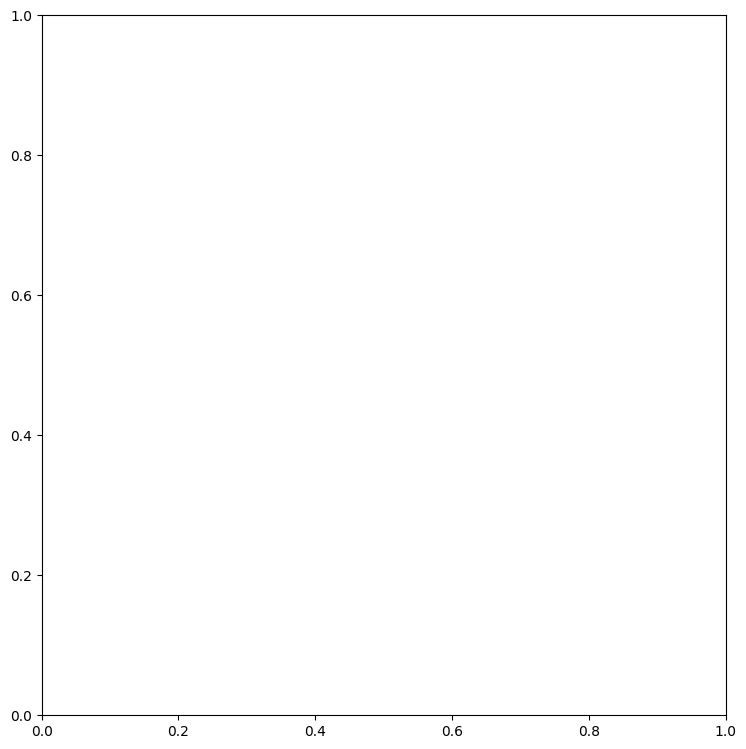

In [9]:
def poolAndMax2D(input, pool=(2,2), v=''):
    v = v.count('+')
    shapeY, shapeX = input.shape[0], input.shape[1] # Original shape of the image
    while shapeY % pool[0] != 0: # If the image Y dimension is not even
        zero_plane = np.zeros_like(input[:pool[0] - input.shape[0] % pool[0], :]) # Create a 2D plane that matches the size of the data
        input = np.concatenate([zero_plane, input], axis=0) # Concatenate the zero-filled plane with the original data
        print(f"Modify Y: {input.shape}, added layer.") if v > 0 else None
    while shapeX % pool[1] != 0: # If the image X dimension is not even
        zero_plane = np.zeros_like(input[:, :pool[1] - input.shape[1] % pool[1]]) # Create a 2D plane that matches the size of the data
        input = np.concatenate([zero_plane, input], axis=1) # Concatenate the zero-filled plane with the original data
        print(f" Modify X: {input.shape}, added layer.") if v > 0 else None
        
    print(input.shape) if v > 0 else None

    shapeY, shapeX = input.shape[0], input.shape[1] # Recompute the shape (new shape)
    newY, newX = int(shapeY/pool[0]), int(shapeX/pool[1]) # The new dimensions that the image will have
    # print(shapeY, shapeX, newY, newX)
    poolList = []
    maxList = [[0 for _ in range(newX)] for _ in range(newY)] # Create a nested list to save the coordinates
    print(f"Convolution from {shapeY} {shapeX} to {len(maxList)} {len(maxList[0])}") if v else None

    c = 0
    perc = 0
    total = int(newX*newY)
    for y in range(0, shapeY, pool[0]):
        for x in range(0, shapeX, pool[1]):
            patch = input[y:y+pool[0], x:x+pool[1]] # Create the patch of pool dimension
            poolList.append(patch.max()) # Get the max value of the patch and append it to the list
            
            indices = np.unravel_index(np.argmax(patch), patch.shape) # Find the indices of the max value
            maxList[int(y / pool[0])][int(x / pool[1])] = (y + indices[0], x + indices[1]) # Add the coordinates in the position of the patch in the list
            
            c+=1
            print(f"{c}/{total}, {perc}%", end="\r") if int(c*100/total) > perc and v > 1 else None 
            perc += 1 if int(c*100/total) > perc else 0
            
    
    print(f"{c}/{total}, {perc}%, DONE!") if v > 1 else None
            
    poolArray = np.array(poolList)
    poolArray = np.reshape(poolArray, (newY, newX))
    maxList = np.array(maxList)
    
    return poolArray, maxList, pool



def deconv2D(input, maxList, pool=(2,2), v=''):
    v = v.count('+')
    shapeY, shapeX = maxList.shape[0], maxList.shape[1]
    newY, newX = int(maxList.shape[0]*pool[0]), int(maxList.shape[1]*pool[1])
    print(f"Deconvolution from {shapeY} {shapeX} to {newY} {newX}") if v > 0 else None
    
    output = [[0 for _ in range(newX)] for _ in range(newY)] # Nested list of size input * pool

    c = 0
    perc = 0
    total = int(shapeY*shapeX)
    for y in range(0, shapeY):
        for x in range(0, shapeX):
            indices = maxList[y, x]
            output[indices[0]][indices[1]] = input[y, x] # Add the value of the pixel to the position of the max pixel of the convolution
            
            c+=1
            print(f"{c}/{total}, {perc}%", end="\r") if int(c*100/total) > perc and v > 1 else None 
            perc += 1 if int(c*100/total) > perc else 0
            
    
    print(f"{c}/{total}, {perc}%, DONE!") if v > 1 else None
    
    output = np.array(output)

    return output

z = 2

plt.figure(figsize=(30,20))

plt.subplot(231)
plt.imshow(image[z])

pool1, maxList1, _ = poolAndMax2D(image[z], v='++')
pool2, maxList2, _ = poolAndMax2D(pool1, v='++')
pool3, maxList3, _ = poolAndMax2D(pool2, v='++')
pool4, maxList4, _ = poolAndMax2D(pool3, v='++')
pool5, maxList5, _ = poolAndMax2D(pool4, v='++')
plt.subplot(232)
plt.imshow(pool5)

pool5 = cv2.GaussianBlur(pool5, (3, 3), 0)
mean =  pool5.mean()
pooled_mask = copy.copy(pool5)
pooled_mask[pool5 > mean] = 255
pooled_mask[pool5 <= mean] = 0
plt.subplot(233)
plt.imshow(pooled_mask)


deconv1 = deconv2D(pooled_mask, maxList5, v='++')
deconv2 = deconv2D(deconv1, maxList4, v='++')
deconv3 = deconv2D(deconv2, maxList3, v='++')
deconv4 = deconv2D(deconv3, maxList2, v='++')
deconv5 = deconv2D(deconv4, maxList1, v='++')

plt.subplot(212)
plt.imshow(deconv5)


In [74]:
def conv_deconv2D(im3d, times=5, verbose='+'):
    verbose = verbose.count('+')
    output = []
    counter = 0
    total = im3d.shape[0]
    for i in im3d:
        pool = [0 for _ in range(times)]
        maxList = [0 for _ in range(times)]
        deconv = [0 for _ in range(times)]
        
        c = 0
        for t in range(times): # CONVOLUTION
            if c == 0:
                pool_n, maxList_n, _ = poolAndMax2D(i)
            else:
                pool_n, maxList_n, _ = poolAndMax2D(pool[c-1])
                
            pool[t] = pool_n
            maxList[t] = maxList_n
            c+=1
        
        
        # MAKE THE MASK
        lastPool = cv2.GaussianBlur(pool[c-1], (3, 3), 0)
        mean = lastPool.mean()
        pooled_mask = copy.copy(lastPool)
        pooled_mask[lastPool > mean] = 255
        pooled_mask[lastPool <= mean] = 0
        
        
        c = times
        for t in range(times): # UPCONVOLUTION
            if c == times:
                deconv_n = deconv2D(pooled_mask, maxList[c-1])
            else:
                deconv_n = deconv2D(deconv[times-c-1], maxList[c-1])
                
            deconv[t] = deconv_n
            c-=1
        
        counter += 1
        print(f"{counter}/{total}", end="\r")
    
        output.append(deconv_n)
    
    output = np.array(output)
    return output

In [4]:
imim = sk.io.imread('domes/70_denoised.tif')
imim = np.transpose(imim[3], axes=(2,0,1))
imim = imim[300]

In [ ]:
plt.figure(figsize=(30,20))

plt.subplot(231)
plt.imshow(imim)

pool1, maxList1, _ = poolAndMax2D(imim, v='++')
pool2, maxList2, _ = poolAndMax2D(pool1, v='++')
pool3, maxList3, _ = poolAndMax2D(pool2, v='++')
pool4, maxList4, _ = poolAndMax2D(pool3, v='++')
pool5, maxList5, _ = poolAndMax2D(pool4, v='++')
plt.subplot(232)
plt.imshow(pool5)

pool5 = cv2.GaussianBlur(pool5, (3, 3), 0)
mean =  pool5.mean()
pooled_mask = copy.copy(pool5)
pooled_mask[pool5 > mean] = 255
pooled_mask[pool5 <= mean] = 0
plt.subplot(233)
plt.imshow(pooled_mask)


deconv1 = deconv2D(pooled_mask, maxList5, v='++')
deconv2 = deconv2D(deconv1, maxList4, v='++')
deconv3 = deconv2D(deconv2, maxList3, v='++')
deconv4 = deconv2D(deconv3, maxList2, v='++')
deconv5 = deconv2D(deconv4, maxList1, v='++')

plt.subplot(212)
plt.imshow(deconv5)

In [75]:
points = conv_deconv2D(image)

In [79]:
print(points.shape)

import tifffile as tiff
tiff.imsave('Dome103_raw_points.tif', points)

(161, 2048, 2048)


C:\Users\SPIM\AppData\Local\Temp\ipykernel_12468\1729828016.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave('Dome103_raw_points.tif', points)


In [ ]:
import napari
import skimage as sk
import numpy as np
points = sk.io.imread('Dome103_raw_points.tif')
image = sk.io.imread('./domes/Dome103_raw.tif')
viewer = napari.Viewer()
viewer.add_image(points[1:, :, :], scale=np.array([1,0.1625,0.1625]))
viewer.add_image(image[1:, :, :], scale=np.array([1,0.1625,0.1625]))

<Image layer 'Image [1]' at 0x21df7715a50>

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Python_vscode\pynapari\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\Python_vscode\pynapari\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "d:\Python_vscode\pynapari\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "d:\Python_vscode\pynapari\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 607, in run_forever
    self._run_once()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1922, in _run_once
    handle._run()
  File "C:\Program Fil

# Mask at the fifth binning

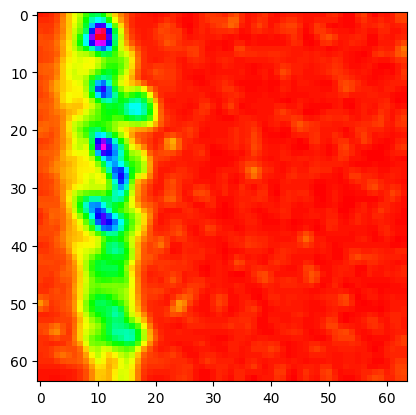

In [63]:
plt.imshow(pool5, cmap='hsv')

142.130126953125
(64, 64)


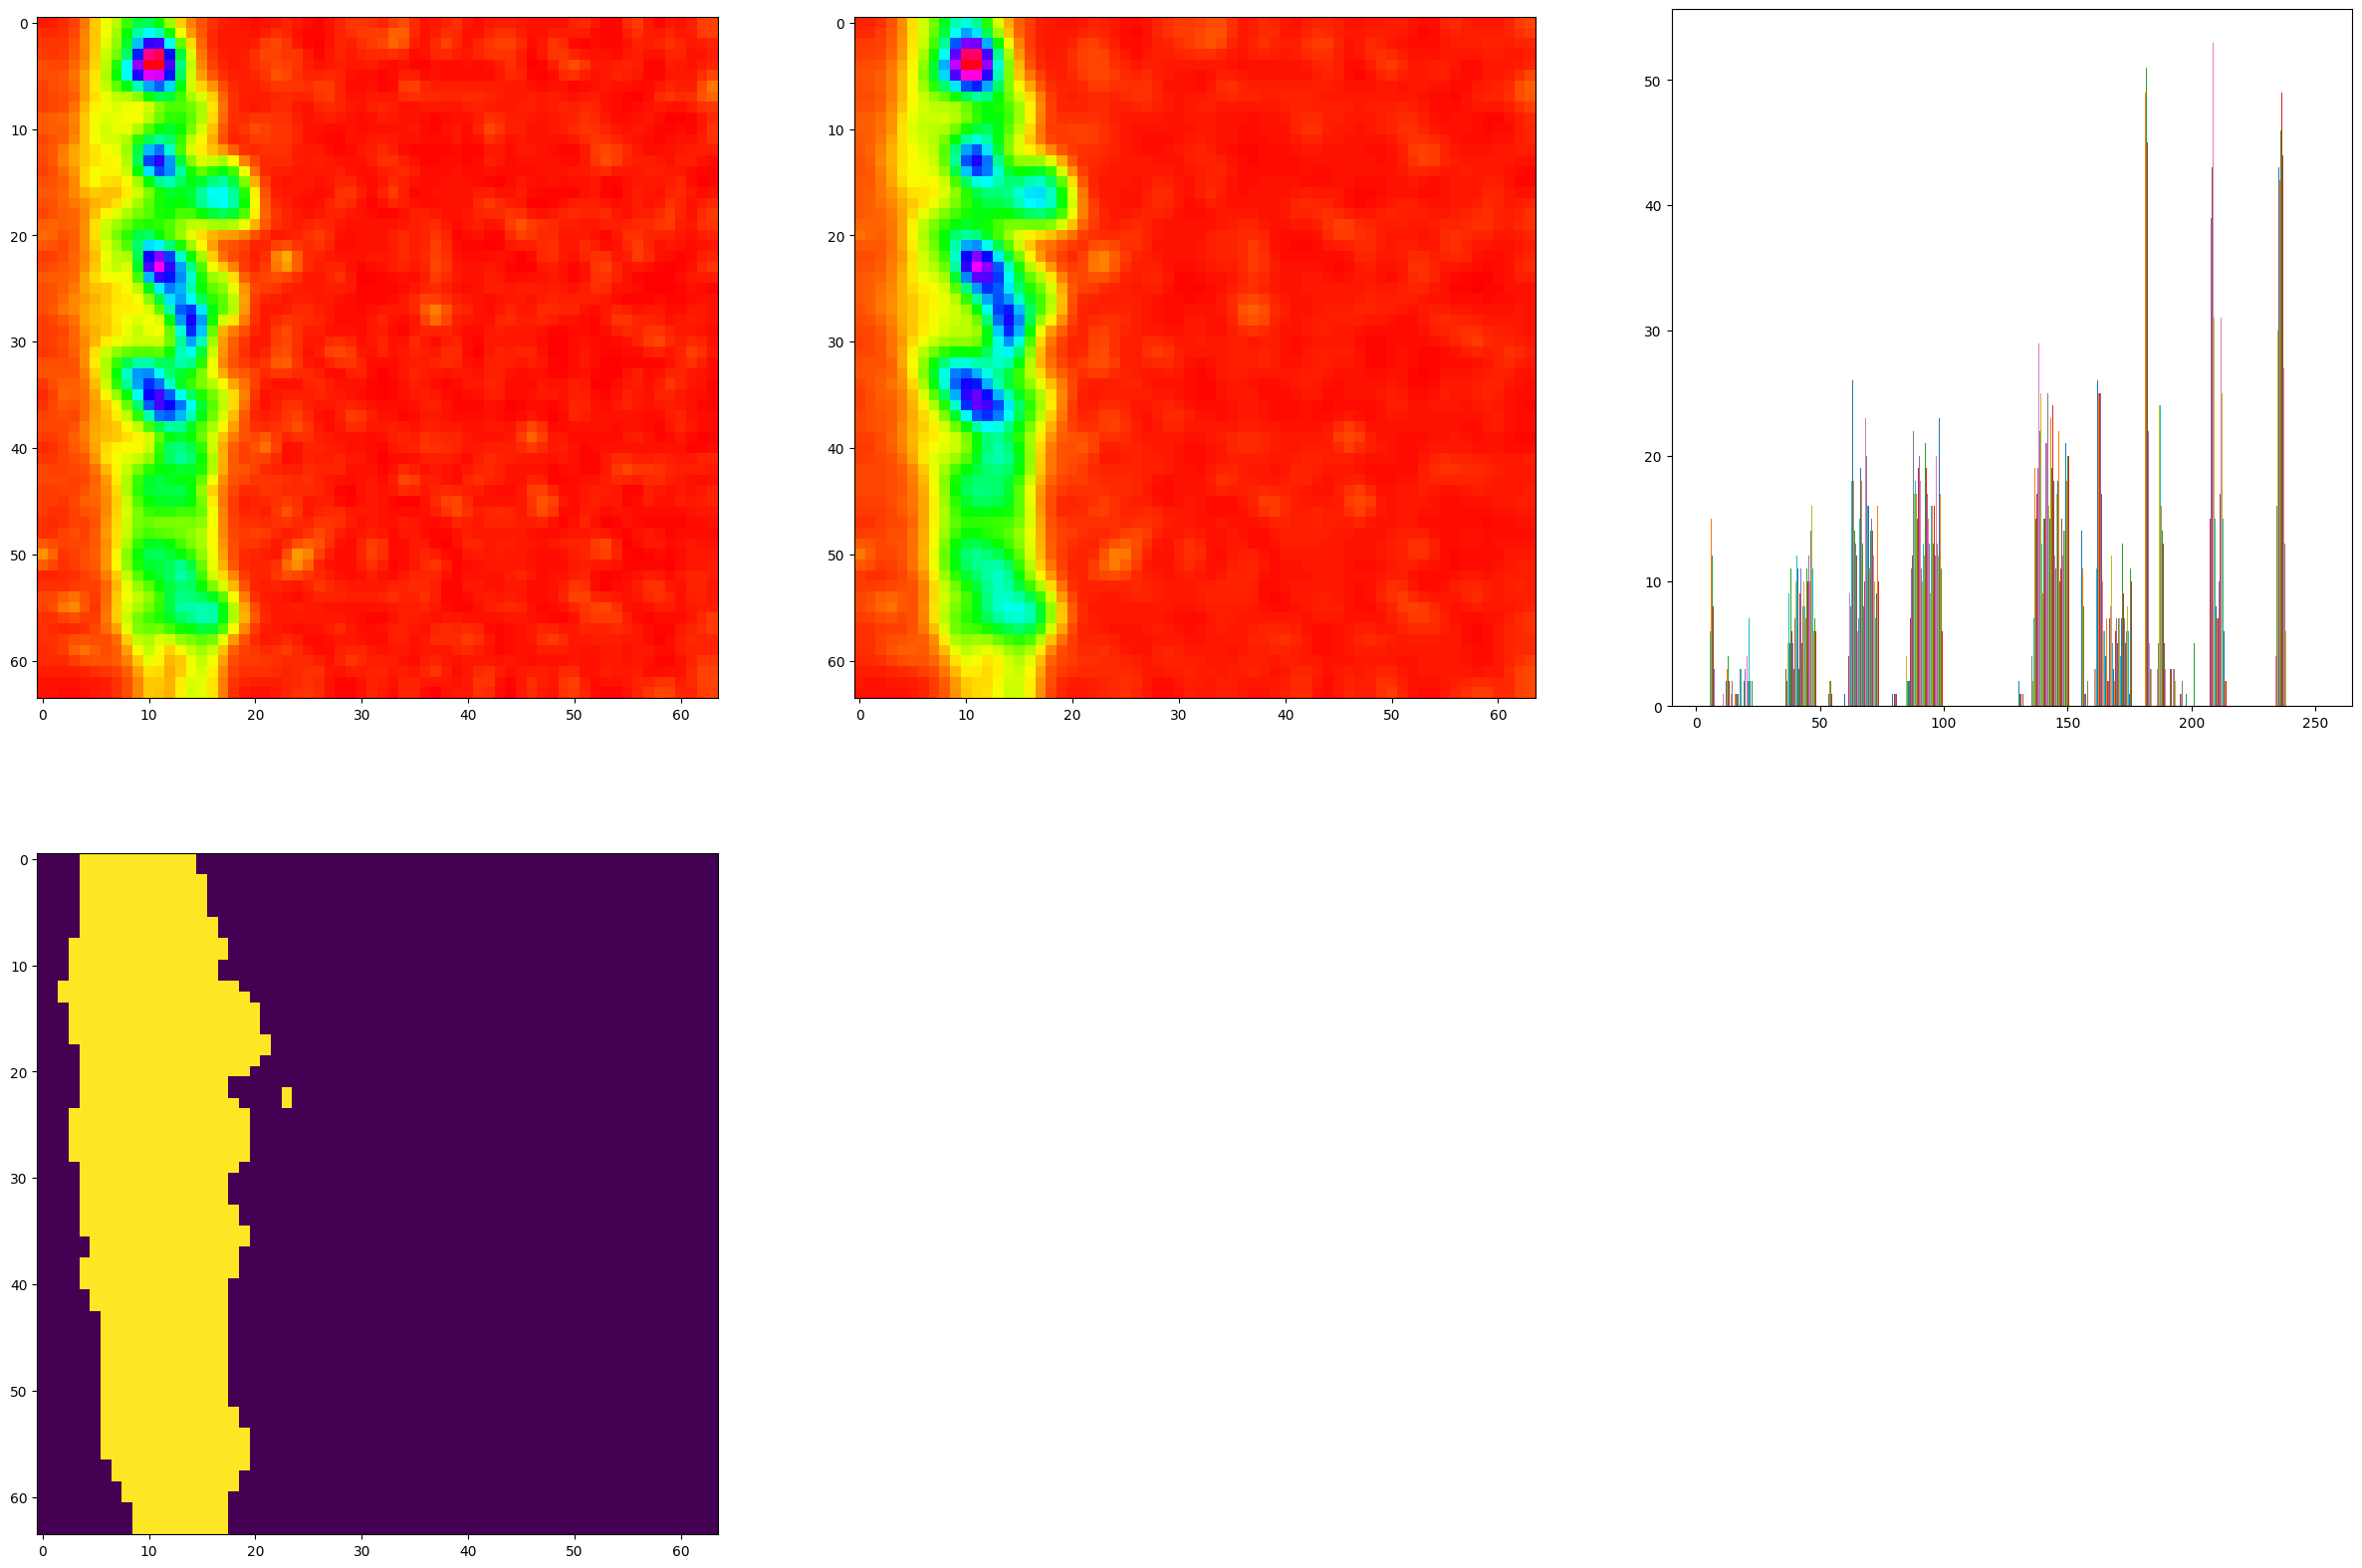

In [64]:
import cv2


plt.figure(figsize=(30,20))

plt.subplot(231)
mask = copy.copy(pool5)
plt.imshow(mask, cmap='hsv')


plt.subplot(232)
mask = cv2.GaussianBlur(mask, (3, 3), 0)
plt.imshow(mask, cmap='hsv')


plt.subplot(233)
hist = cv2.equalizeHist(mask.astype(np.uint8))
plt.hist(hist)



plt.subplot(234)
mean =  mask.mean()
print(mean)
mask2 = copy.copy(mask)
mask2[mask > mean] = 255
mask2[mask <= mean] = 0

# _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)

plt.imshow(mask2)


print(mask2.shape)

In [7]:
def poolAndMax2D(input, binshape=(2,2), v=''):
        '''
        Convolutes the image and saves the positions of the brightests pixels.
        '''
        v = v.count('+')
        shapeY, shapeX = input.shape[0], input.shape[1] # Original shape of the image
        while shapeY % binshape[0] != 0: # If the image Y dimension is not even
            zero_plane = np.zeros_like(input[:binshape[0] - input.shape[0] % binshape[0], :]) # Create a 2D plane that matches the size of the data
            input = np.concatenate([zero_plane, input], axis=0) # Concatenate the zero-filled plane with the original data
            print(f"Modify Y: {input.shape}, added layer.") if v > 0 else None
            shapeY = input.shape[0]
        while shapeX % binshape[1] != 0: # If the image X dimension is not even
            zero_plane = np.zeros_like(input[:, :binshape[1] - input.shape[1] % binshape[1]]) # Create a 2D plane that matches the size of the data
            input = np.concatenate([zero_plane, input], axis=1) # Concatenate the zero-filled plane with the original data
            print(f" Modify X: {input.shape}, added layer.") if v > 0 else None
            shapeX =  input.shape[1]
            
        print(input.shape) if v > 0 else None

        shapeY, shapeX = input.shape[0], input.shape[1] # Recompute the shape (new shape)
        newY, newX = int(shapeY/binshape[0]), int(shapeX/binshape[1]) # The new dimensions that the image will have
        # print(shapeY, shapeX, newY, newX)
        poolList = []
        maxList = [[0 for _ in range(newX)] for _ in range(newY)] # Create a nested list to save the coordinates
        print(f"Convolution from {shapeY} {shapeX} to {len(maxList)} {len(maxList[0])}") if v else None

        c = 0
        perc = 0
        total = int(newX*newY)
        for y in range(0, shapeY, binshape[0]):
            for x in range(0, shapeX, binshape[1]):
                patch = input[y:y+binshape[0], x:x+binshape[1]] # Create the patch of pool dimension
                poolList.append(patch.max()) # Get the max value of the patch and append it to the list
                
                indices = np.unravel_index(np.argmax(patch), patch.shape) # Find the indices of the max value
                maxList[int(y / binshape[0])][int(x / binshape[1])] = (y + indices[0], x + indices[1]) # Add the coordinates in the position of the patch in the list
                
                c+=1
                print(f"{c}/{total}, {perc}%", end="\r") if int(c*100/total) > perc and v > 1 else None 
                perc += 1 if int(c*100/total) > perc else 0
                
        
        print(f"{c}/{total}, {perc}%, DONE!") if v > 1 else None
                
        poolArray = np.array(poolList)
        poolArray = np.reshape(poolArray, (newY, newX))
        maxList = np.array(maxList)
        
        return poolArray, maxList, binshape

In [16]:
def deconv2D(input, maxList, binshape=(2,2), v=''):
    '''
    Upvonvolve the image using the list where the pixel whas the brightest.
    '''
    v = v.count('+')
    shapeY, shapeX = maxList.shape[0], maxList.shape[1]
    newY, newX = int(maxList.shape[0]*binshape[0]), int(maxList.shape[1]*binshape[1])
    print(f"Deconvolution from {shapeY} {shapeX} to {newY} {newX}") if v > 0 else None
    
    output = [[0 for _ in range(newX)] for _ in range(newY)] # Nested list of size input * pool

    c = 0
    perc = 0
    total = int(shapeY*shapeX)
    for y in range(0, shapeY):
        for x in range(0, shapeX):
            indices = maxList[y, x]
            output[indices[0]][indices[1]] = input[y, x] # Add the value of the pixel to the position of the max pixel of the convolution
            
            c+=1
            print(f"{c}/{total}, {perc}%", end="\r") if int(c*100/total) > perc and v > 1 else None 
            perc += 1 if int(c*100/total) > perc else 0
            
    
    print(f"{c}/{total}, {perc}%, DONE!") if v > 1 else None
    
    output = np.array(output)

    return output

In [139]:
imim = sk.io.imread('domes/70_denoised.tif')
imim = np.transpose(imim[3], axes=(2,0,1))
imim = imim[300]

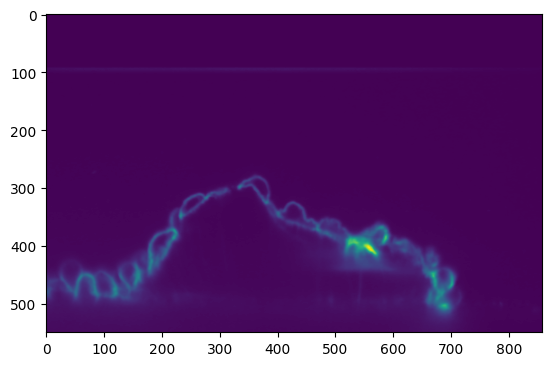

In [140]:
plt.imshow(imim)

In [141]:
im1, max1, _ = poolAndMax2D(imim, binshape=(2,2))
im2, max2, _ = poolAndMax2D(im1, binshape=(2,2))
im3, max3, _ = poolAndMax2D(im2, binshape=(2,2))
im4, max4, _ = poolAndMax2D(im3, binshape=(2,2))

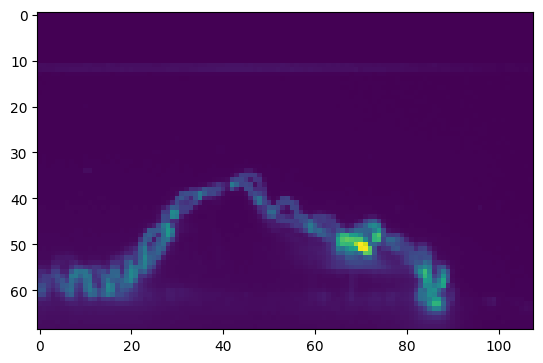

In [142]:
plt.imshow(im3)

In [143]:
lastPool = cv2.GaussianBlur(im3, (3, 3), 0) # Gaussian
mean = lastPool.mean()
pooled_mask = copy.copy(lastPool)
pooled_mask[lastPool > mean] = 255 # Threshold by the mean of the gaussian
pooled_mask[lastPool <= mean] = 0

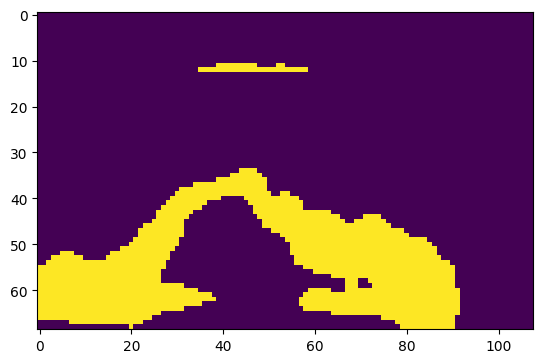

In [144]:
plt.imshow(pooled_mask)

In [145]:
up1 = deconv2D(pooled_mask, max3, binshape=(2,2))
up2 = deconv2D(up1, max2, binshape=(2,2))
up3 = deconv2D(up2, max1, binshape=(2,2))
up4 = deconv2D(up3, max1, binshape=(2,2))

In [146]:
up4 = up4.astype(np.uint16)

In [147]:
print(up4.max())
print(up4.min())
print(up4)

255
0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


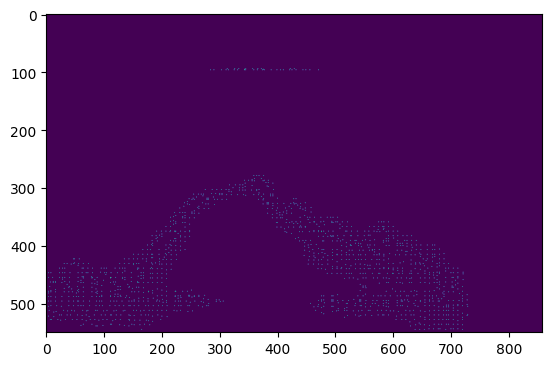

In [148]:
plt.imshow(up3)
up4 = up3

In [149]:
from scipy.spatial import Delaunay

class MyDelaunay(Delaunay):
    def __init__(self, points, delaunay_to_2D):
        super().__init__(points)
        self.delaunay_to_2D = delaunay_to_2D
        if delaunay_to_2D:
            self.simplices = self.convert_to_2D(self.simplices)
            
    def convert_to_2D(self, simplex):
        simplex_2D = []
        for i in simplex:
            simplex_2D.append([i[0], i[1], i[2]])
            simplex_2D.append([i[0], i[1], i[3]])
            simplex_2D.append([i[0], i[2], i[3]])
            simplex_2D.append([i[1], i[2], i[3]])
        return np.array(simplex_2D)

    def triangle_area(self, simplex): # At the moment only working in 2D triangles
        p1, p2, p3 = self.points[simplex]
        return 0.5 * np.abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))

    def calculate_triangle_areas(self):
        return [self.triangle_area(simplex) for simplex in self.simplices]

    def largest_triangle_angle(self):
        largest_angles = []

        for simplex in self.simplices:
            p1, p2, p3 = self.points[simplex]

            # Calculate vectors
            v1 = p2 - p1
            v2 = p3 - p1
            v3 = p3 - p2

            # Calculate angles
            angle1 = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            angle2 = np.arccos(np.dot(-v1, v3) / (np.linalg.norm(v1) * np.linalg.norm(v3)))
            angle3 = np.pi - angle1 - angle2

            largest_angle = max(angle1, angle2, angle3)
            largest_angles.append(np.degrees(largest_angle))

        return largest_angles
    
    def largest_triangle_side(self):
        largest_sides = []
        
        for simplex in self.simplices:
            p1, p2, p3 = self.points[simplex]
            largest_side = max([np.sqrt((p1[0]-p1[1])**2+(p2[0]-p2[1])**2),
                                np.sqrt((p1[0]-p1[1])**2+(p3[0]-p3[1])**2),
                                np.sqrt((p2[0]-p2[1])**2+(p3[0]-p3[1])**2)])
            largest_sides.append(largest_side)
        
        return largest_sides

def delaunay(i, threshold_area, threshold_angle, delaunay_to_2D=True):
    '''
    '''  
    tri = MyDelaunay(i, delaunay_to_2D)
    # Calculate triangle areas and largest angles
    triangle_areas = np.array(tri.calculate_triangle_areas())
    largest_angles = np.array(tri.largest_triangle_angle())

    # Create masks based on thresholds
    mask_area = (triangle_areas - triangle_areas.mean()) < threshold_area * triangle_areas.std()
    mask_angle = largest_angles < threshold_angle

    # Combine masks using logical AND (you can also use | for OR)
    combined_mask = mask_area & mask_angle

    filtered_simplices = tri.simplices[combined_mask]

    
    return filtered_simplices

def delaunay_non_filtered(i, threshold_area, threshold_angle, delaunay_to_2D=True):
    '''
    '''  
    tri = MyDelaunay(i, delaunay_to_2D)
 
    
    return tri.simplices
    
def bresenham_line(x1, y1, x2, y2):
    points = []

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    error = dx - dy
    x, y = x1, y1

    while True:
        points.append((x, y))
        if x == x2 and y == y2:
            break
        e2 = 2 * error
        if e2 > -dy:
            error -= dy
            x += sx

        if e2 < dx:
            error += dx
            y += sy

    return points

def bresenham_line_3d(x1, y1, z1, x2, y2, z2):
    ListOfPoints = []
    ListOfPoints.append((x1, y1, z1))
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    dz = abs(z2 - z1)
    if (x2 > x1):
        xs = 1
    else:
        xs = -1
    if (y2 > y1):
        ys = 1
    else:
        ys = -1
    if (z2 > z1):
        zs = 1
    else:
        zs = -1

    # Driving axis is X-axis"
    if (dx >= dy and dx >= dz):        
        p1 = 2 * dy - dx
        p2 = 2 * dz - dx
        while (x1 != x2):
            x1 += xs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dx
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dx
            p1 += 2 * dy
            p2 += 2 * dz
            ListOfPoints.append((x1, y1, z1))

    # Driving axis is Y-axis"
    elif (dy >= dx and dy >= dz):       
        p1 = 2 * dx - dy
        p2 = 2 * dz - dy
        while (y1 != y2):
            y1 += ys
            if (p1 >= 0):
                x1 += xs
                p1 -= 2 * dy
            if (p2 >= 0):
                z1 += zs
                p2 -= 2 * dy
            p1 += 2 * dx
            p2 += 2 * dz
            ListOfPoints.append((x1, y1, z1))

    # Driving axis is Z-axis"
    else:        
        p1 = 2 * dy - dz
        p2 = 2 * dx - dz
        while (z1 != z2):
            z1 += zs
            if (p1 >= 0):
                y1 += ys
                p1 -= 2 * dz
            if (p2 >= 0):
                x1 += xs
                p2 -= 2 * dz
            p1 += 2 * dy
            p2 += 2 * dx
            ListOfPoints.append((x1, y1, z1))
            
    return ListOfPoints

def get_coords(i):
    coords = np.transpose(np.nonzero(i != 0))
        
    return coords

In [150]:
coords = get_coords(up4)
mask = np.zeros((up4.shape[0], up4.shape[1]))

morph_close_k=20
morph_open_k=10
m_ball=5
threshold_area=0.1
threshold_angle=90

if len(coords) > 10:
    filtered_simplices = delaunay_non_filtered(coords, threshold_area, threshold_angle, delaunay_to_2D=False)
    filtered_simplices = delaunay(coords, threshold_area, threshold_angle, delaunay_to_2D=False)
    
    
    for i in filtered_simplices: # Iterate over the triangles and put 1 to the lines that unite the dots
        to_1 = bresenham_line(*coords[i][0], *coords[i][1])
        to_1 += list(bresenham_line(*coords[i][1], *coords[i][2]))
        to_1 += list(bresenham_line(*coords[i][0], *coords[i][2]))
        for j in to_1:
            mask[j] = 1
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((morph_close_k, morph_close_k))) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((morph_open_k, morph_open_k)))

    mask = np.resize(mask, imim.shape)

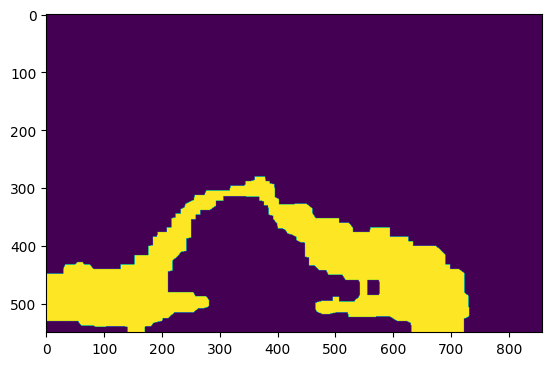

In [151]:
plt.imshow(mask)

In [152]:
print(im4.shape)

(35, 54)


im3.shape

In [153]:
im3.shape

(69, 108)

In [154]:
mask = mask.astype(np.uint16)

In [155]:
import tifffile as tiff
tiff.imwrite('../ppujol/dottamine_steps/mask_3times.tif', mask, imagej=True)

In [156]:
full = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((15, 15)))

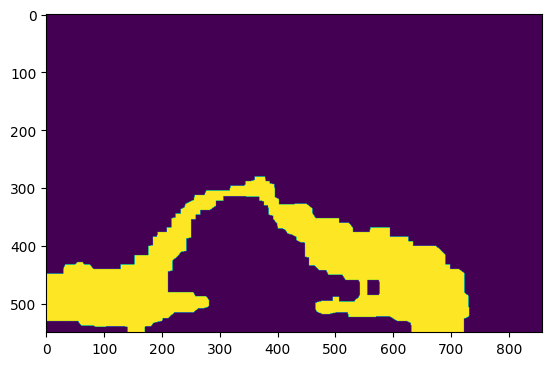

In [157]:
plt.imshow(mask)

In [158]:
morph_close_k=20
morph_open_k=10
mask_i = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((morph_close_k, morph_close_k))) 
mask_i = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((morph_open_k, morph_open_k)))
